In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

from joblib import Parallel, delayed
import pylops
import pyproximal

import csv

In [2]:
def matrix_completion_k(k):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]
    
    # This is the indices of existing data
    existing_indices = np.where(existing_data_flatten[:, num_probes*k:num_probes*(k+1)].ravel())
    
    nx, ny = bc1_nan_map.shape
    Rop = pylops.Restriction(ny*nx, 
                         existing_indices[0], dtype='float64')
    
    Uy, Sy, Vhy = np.linalg.svd(bc1_nan_map, full_matrices=False)
    
    mu1 = 0.5 * np.sum(Sy)
    y = Rop * bc1_map.ravel()
    f = pyproximal.L2(Rop, y)
    g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

    Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                        tau=1., niter=100, show=False)
    Xpgc = Xpgc.reshape(nx, ny)
    
    return Xpgc

def interpolate_polymers(polys):
    # Notice here that the input polymer shape is different!!
    num_cells, num_probes, num_coords = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[c, :, :]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_bool = np.isnan(curr_coords)
            valid_indices = np.where(~missing_bool)[0]
            missing_indices = np.where(missing_bool)[0]
            # print(missing_indices, valid_indices, curr_coords[valid_indices])
            interp_coords = np.interp(missing_indices, valid_indices, curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [3]:
# Create an array with missing values (np.nan)
data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0])

# Identify indices of the known (non-nan) values
known_indices = np.where(~np.isnan(data))[0]
known_values = data[known_indices]

# Identify indices of the missing (nan) values
missing_indices = np.where(np.isnan(data))[0]

# Use np.interp to fill in the missing values
data[missing_indices] = np.interp(missing_indices, known_indices, known_values)

print(data)

[1. 2. 3. 4. 5. 6. 7.]


In [4]:
p = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_50_1000_20.0_10000.pkl'
    
# Load the dataset from that pickle file 
print("Loading dataset...")
print(p)
dataset_list, param_dict = load_dataset(p)



Loading dataset...
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_50_1000_20.0_10000.pkl


Initializing dataset...


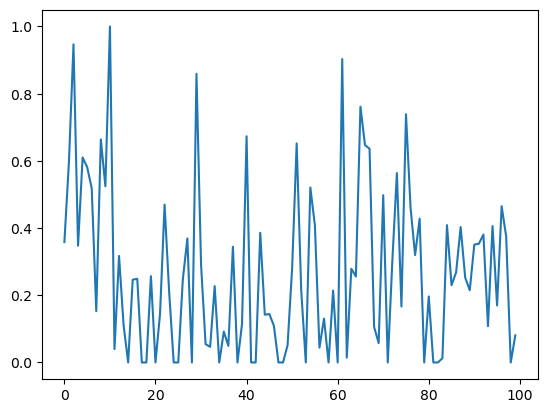

In [5]:
print('Initializing dataset...')
mc_pred_Sy_err_list = []
mc_pred_surface_err_list = []
mean_impute_err_list = []

template_list = dataset_list[1]['template_chain_list']
X = dataset_list[1]['observation_list']
label_list = dataset_list[1]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.2, 0.3, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
polys_with_nan = np.array([x for x in X])
polys_with_nan = polys_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = 0
    observations_with_nan[i, :, missing_indices] = 0
    polys_with_nan[i, missing_indices, :] = np.nan
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    


In [18]:
S = np.linalg.svd(observations_with_nan[0], full_matrices=False, compute_uv=False)

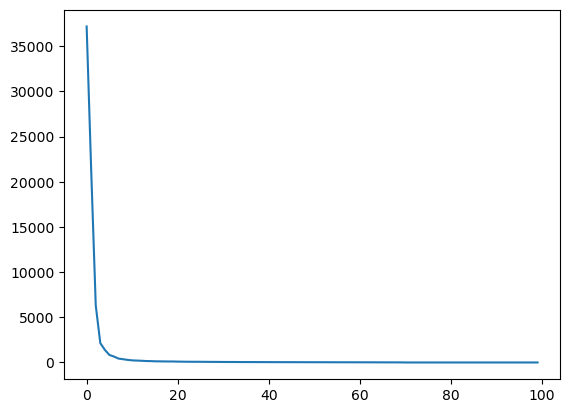

In [23]:
plt.plot(S)

In [25]:
from kneed import KneeLocator

In [26]:
kneedle = KneeLocator(range(len(S)), S, curve='convex', direction='decreasing')


In [28]:
elbow_point = kneedle.elbow
print("Elbow point index:", elbow_point)
print("Elbow point value:", S[elbow_point])

Elbow point index: 5
Elbow point value: 831.4067816774068


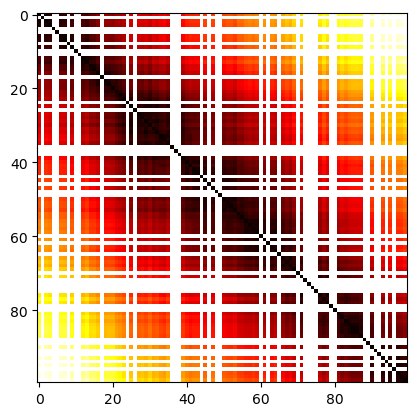

In [7]:
plt.imshow(squareform(pdist(polys_with_nan[0])), cmap='hot')

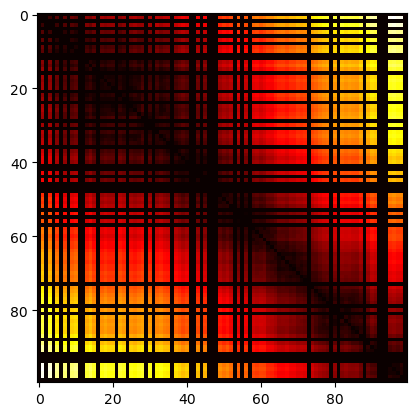

In [8]:
plt.imshow(observations_with_nan[77], cmap='hot')

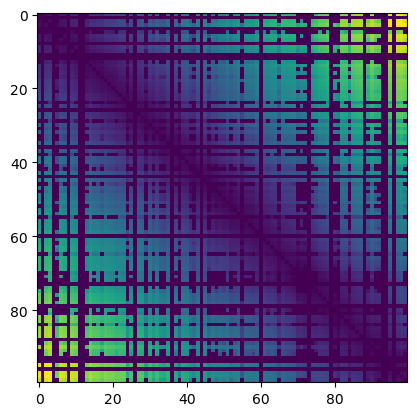

In [9]:
plt.imshow(np.nanmedian(observations_with_nan, axis=0))

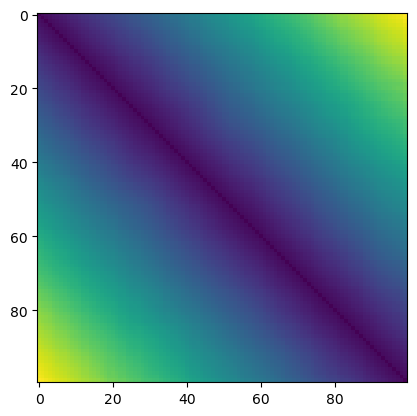

In [10]:
plt.imshow(np.nanmedian([squareform(pdist(x)) for x in X], axis=0))

In [72]:
mean_impute_maps.shape

(10000, 100, 100)

In [6]:
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])
mean_impute_polys = interpolate_polymers(polys_with_nan)
mean_impute_maps = np.array([squareform(pdist(mean_impute_polys[:, :, x])) for x in range(mean_impute_polys.shape[2])])
mean_impute_flatten = np.array([x.flatten() for x in mean_impute_maps])


In [8]:
S = np.linalg.svd(observations_flatten_with_nan, full_matrices=False, compute_uv=False)

In [15]:
np.sum(S > 1)

4851

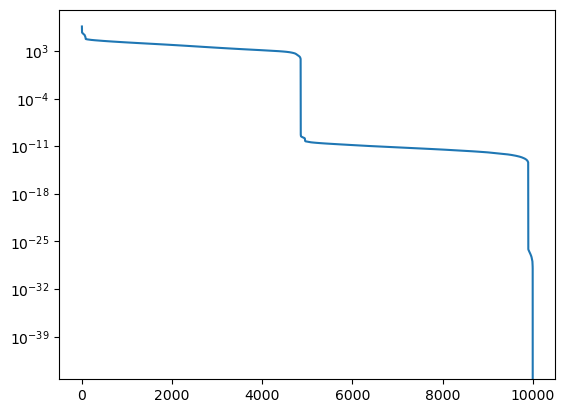

In [17]:
plt.semilogy(S)

In [73]:
print('Running matrix completion Nuclear L1 Ball...')
mc_pred_Sy = Parallel(n_jobs=-1)(delayed(matrix_completion_k)(k) for k in range(num_probes))

Running matrix completion Nuclear L1 Ball...


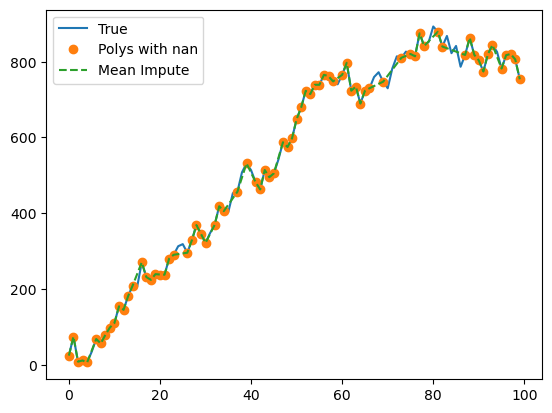

In [76]:
plt.plot(X[shuffle_indices, :, :][0, :, 0], label='True')
plt.plot(polys_with_nan[0, :, 0], 'o', label='Polys with nan')
plt.plot(mean_impute_polys[:, 0, 0], '--', label='Mean Impute')
plt.legend()

In [77]:
mc_pred_Sy = np.hstack(mc_pred_Sy)

In [78]:
print('Calculating performance metrics...')
mc_pred_Sy_err = np.linalg.norm(mc_pred_Sy - observations_flatten)
mean_impute_err = np.linalg.norm(mean_impute_flatten - observations_flatten)

Calculating performance metrics...


In [79]:
print('MC error', mc_pred_Sy_err)
print('Mean impute error', mean_impute_err)
print('MC/Mean impute error ratio', mc_pred_Sy_err / mean_impute_err)

MC error 1205547.0694022558
Mean impute error 205490.34751137617
MC/Mean impute error ratio 5.866684659412119


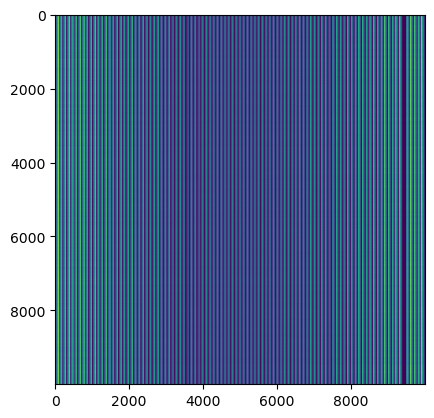

In [80]:
plt.imshow(mc_pred_Sy)

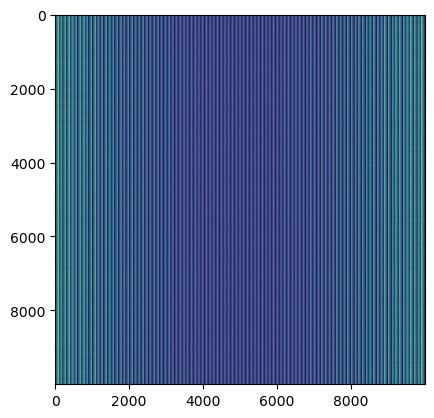

In [81]:
plt.imshow(mean_impute_flatten)

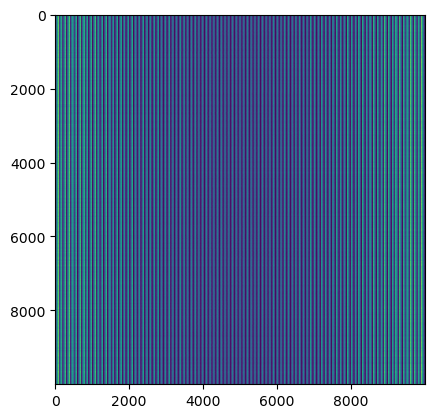

In [82]:
plt.imshow(observations_flatten)

In [86]:
# Reshape flatten matrix back to original shape
mc_pred_dmap = mc_pred_Sy.reshape(num_observations, num_probes, num_probes)

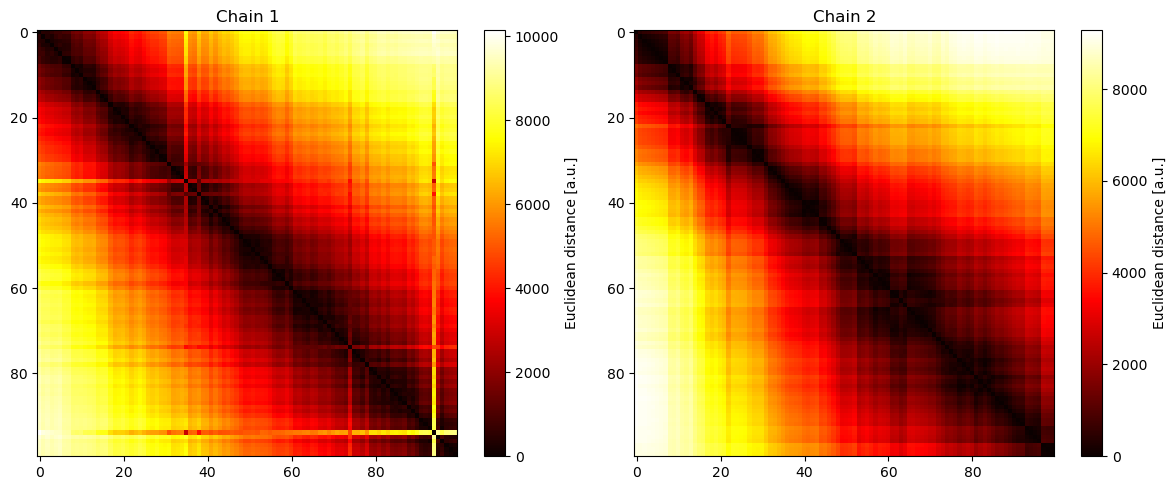

In [87]:
compare_distance_maps(mc_pred_dmap[78], mean_impute_maps[78])

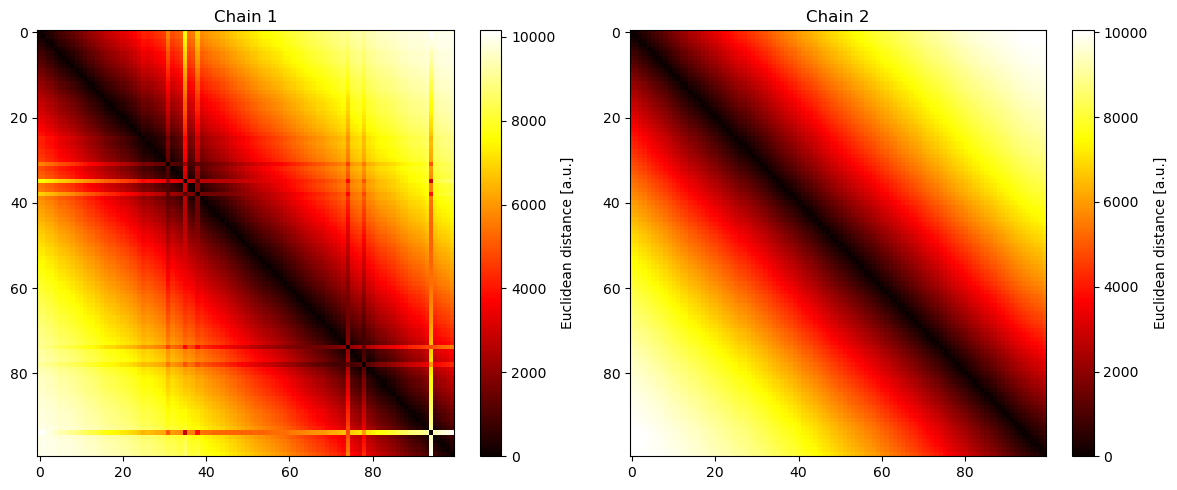

In [88]:
compare_distance_maps(np.nanmedian(mc_pred_dmap, axis=0), np.nanmedian(mean_impute_maps, axis=0))

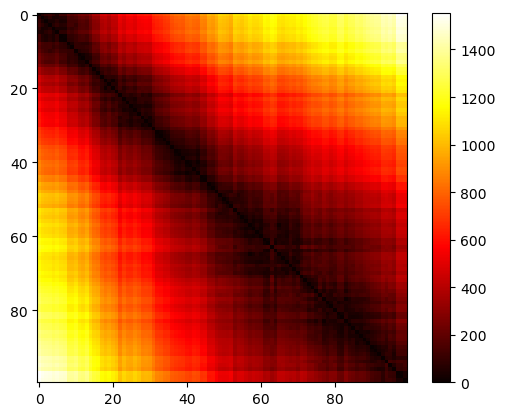

In [90]:
plt.imshow(squareform(pdist(X[shuffle_indices, :, :][78])), cmap='hot')
plt.colorbar()

In [32]:
mc_sc_err_list = []
mi_sc_err_list = []
for i in range(10000):
    mc_sc_err = np.linalg.norm(squareform(pdist(X[i])) - mc_pred_dmap[i])
    mi_sc_err = np.linalg.norm(squareform(pdist(X[i])) - mean_impute_maps[i])
    mc_sc_err_list.append(mc_sc_err)
    mi_sc_err_list.append(mi_sc_err)

(array([  1.,   1.,   0.,   0.,   2.,   2.,   6.,   4.,   4.,   4.,   7.,
         16.,  20.,  29.,  39.,  53.,  65.,  92., 101., 119., 139., 141.,
        167., 169., 217., 207., 196., 260., 265., 251., 275., 261., 253.,
        297., 301., 242., 248., 288., 244., 214., 263., 248., 236., 243.,
        211., 203., 214., 197., 211., 179., 170., 175., 181., 163., 147.,
        134., 137., 125., 130., 107.,  90.,  91.,  94.,  79.,  84.,  76.,
         76.,  69.,  51.,  48.,  37.,  49.,  38.,  32.,  35.,  23.,  21.,
         15.,  20.,  15.,   8.,  16.,   6.,   5.,   5.,  10.,   4.,   3.,
          4.,   2.,   6.,   2.,   4.,   4.,   0.,   1.,   1.,   0.,   0.,
          2.]),
 array([ 5409.22360305,  5676.20305153,  5943.18250001,  6210.16194848,
         6477.14139696,  6744.12084544,  7011.10029391,  7278.07974239,
         7545.05919087,  7812.03863934,  8079.01808782,  8345.9975363 ,
         8612.97698477,  8879.95643325,  9146.93588173,  9413.9153302 ,
         9680.89477868,  9947.

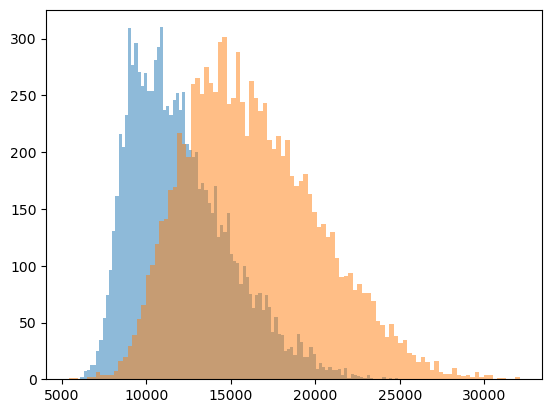

In [34]:
plt.hist(mc_sc_err_list, bins=100, alpha=0.5, label='MC')
plt.hist(mi_sc_err_list, bins=100, alpha=0.5, label='MI')

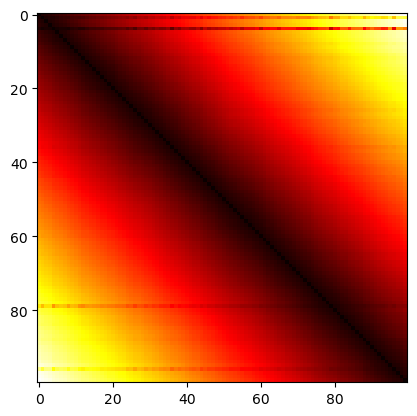

In [21]:
plt.imshow(np.nanmedian(mc_pred_dmap, axis=0), cmap='hot')

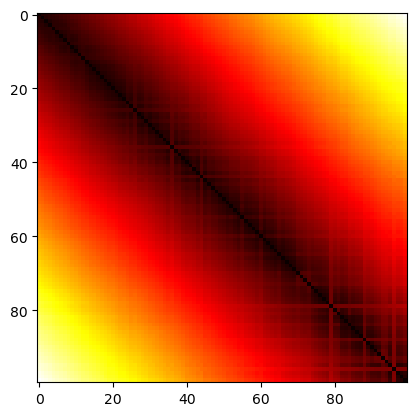

In [22]:
plt.imshow(np.nanmedian(mean_impute_maps, axis=0), cmap='hot')

In [43]:
# Try with single distance maps

bc1_nan_map = observations_with_nan[0, :, :]

# This is the indices of existing data
existing_indices = np.where(existing_data[0, :, :].ravel())

nx, ny = bc1_nan_map.shape
Rop = pylops.Restriction(ny*nx, 
                        existing_indices[0], dtype='float64')

Sy = np.linalg.svd(bc1_nan_map, full_matrices=False, compute_uv=False)

mu1 = np.sum(Sy)
y = Rop * bc1_nan_map.ravel()
f = pyproximal.L2(Rop, y)
g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                    tau=1., niter=100, show=False)
Xpgc = Xpgc.reshape(nx, ny)
    

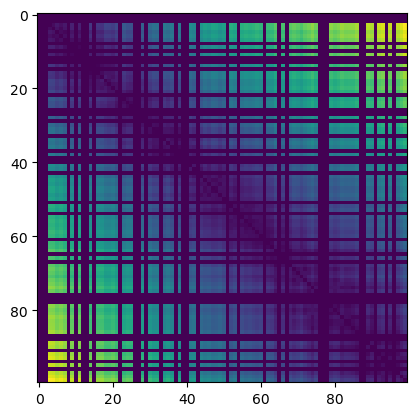

In [44]:
plt.imshow(Xpgc)

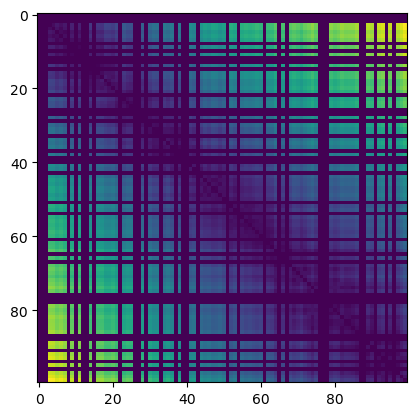

In [42]:
plt.imshow(bc1_nan_map)